In [1]:
# Optional: run if a package is missing
!pip install -q pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost joblib


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# plotting defaults
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")


In [7]:
DATA_PATH = "/mnt/data/Archive_Root_Directory/creditcard.csv"


In [12]:
import glob

files = glob.glob("/mnt/data/**/*.csv", recursive=True)
print("CSV files found:", files)

# Pick the first CSV found
DATA_PATH = files[0] if files else None

if DATA_PATH:
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataset shape:", df.shape)
else:
    print("No CSV file found in /mnt/data")


CSV files found: []
No CSV file found in /mnt/data


In [14]:
from google.colab import files  # only in Colab
uploaded = files.upload()       # this will open a file upload dialog

# After uploading, you can get the filename
import pandas as pd
import io

filename = list(uploaded.keys())[0]  # get the uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Loaded dataset shape:", df.shape)
df.head()


Saving creditcard.csv to creditcard.csv
Loaded dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
# Class distribution
print("Class counts:\n", df['Class'].value_counts())
print("\nClass proportions:\n", df['Class'].value_counts(normalize=True))

# Basic stats & missing checks
display(df[['Time','Amount']].describe().T)
print("\nMissing values per column:")
print(df.isna().sum())


Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Class proportions:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16



Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


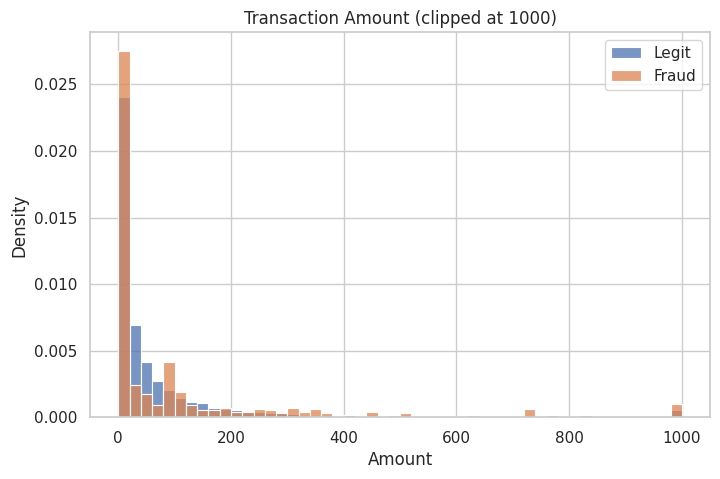

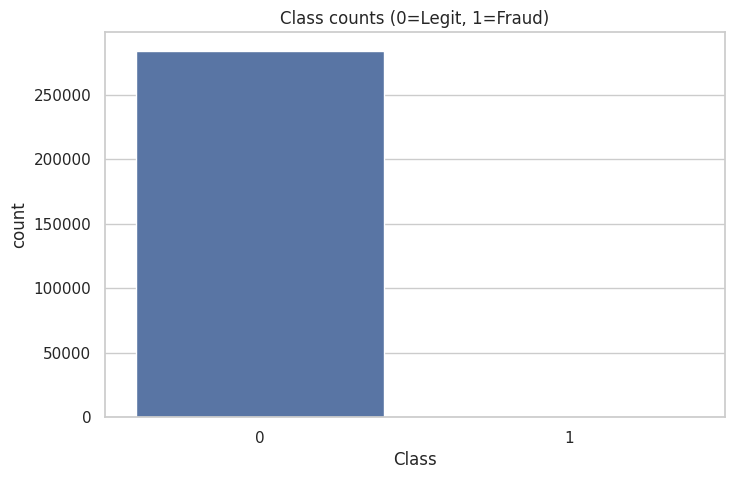

In [16]:
# Amount distribution (clip high values for readability)
plt.figure()
sns.histplot(df[df['Class']==0]['Amount'].clip(upper=1000), label='Legit', stat='density', bins=50)
sns.histplot(df[df['Class']==1]['Amount'].clip(upper=1000), label='Fraud', stat='density', bins=50)
plt.title("Transaction Amount (clipped at 1000)")
plt.legend()
plt.show()

# Class count
plt.figure()
sns.countplot(x='Class', data=df)
plt.title('Class counts (0=Legit, 1=Fraud)')
plt.show()


In [17]:
data = df.copy()

# Scale Amount
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data.drop(['Amount'], axis=1, inplace=True)

# Convert Time (seconds) to hour of day then cyclical features
data['Hour'] = ((data['Time'] // 3600) % 24).astype(int)
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
data.drop(['Time','Hour'], axis=1, inplace=True)

print("Columns after preprocessing:", data.columns.tolist())


Columns after preprocessing: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_scaled', 'Hour_sin', 'Hour_cos']


In [18]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))


Train shape: (227845, 31) Test shape: (56962, 31)
Train class counts: [227451    394]
Test class counts: [56864    98]


In [19]:
print("Before SMOTE:", np.bincount(y_train))

# Note: don't use n_jobs parameter if your imblearn version doesn't support it
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_res))
# Convert to DataFrame for convenience
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res, name='Class')


Before SMOTE: [227451    394]
After SMOTE: [227451 227451]


In [20]:
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_res, y_train_res)

y_proba_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = lr.predict(X_test)

print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("\nClassification report (threshold 0.5):")
print(classification_report(y_test, y_pred_lr, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression ROC AUC: 0.9721507922949709

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0     0.9999    0.9735    0.9865     56864
           1     0.0564    0.9184    0.1063        98

    accuracy                         0.9734     56962
   macro avg     0.5281    0.9460    0.5464     56962
weighted avg     0.9982    0.9734    0.9850     56962

Confusion Matrix:
 [[55359  1505]
 [    8    90]]


In [21]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_clf.fit(X_train_res, y_train_res)

y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]
y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report (threshold 0.5):")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:36:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC AUC: 0.9817635059088351

Classification report (threshold 0.5):
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8384    0.8469    0.8426        98

    accuracy                         0.9995     56962
   macro avg     0.9191    0.9233    0.9212     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix:
 [[56848    16]
 [   15    83]]


<Figure size 800x500 with 0 Axes>

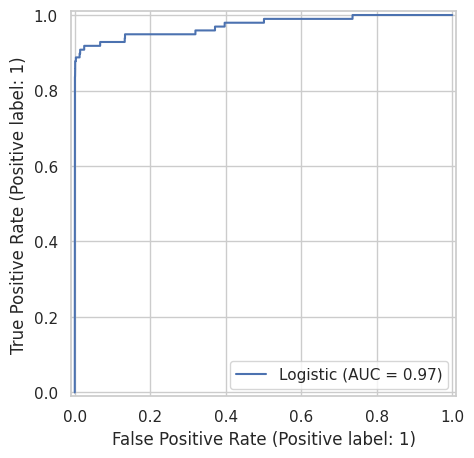

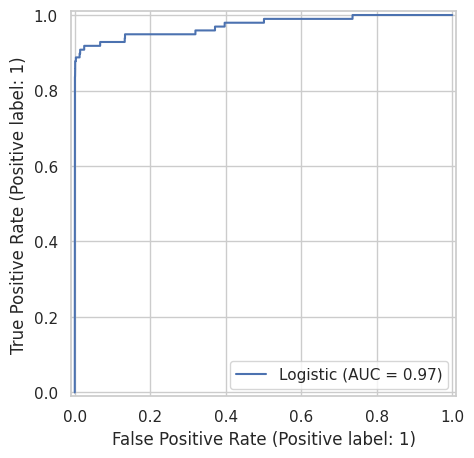

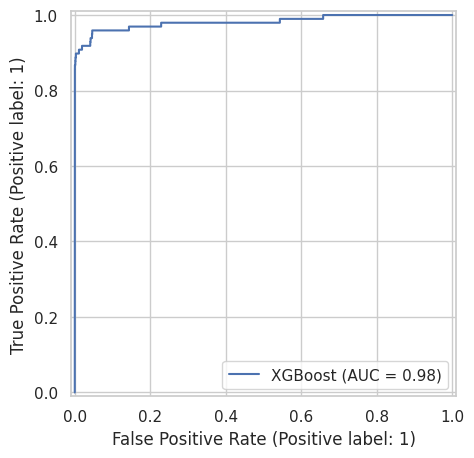

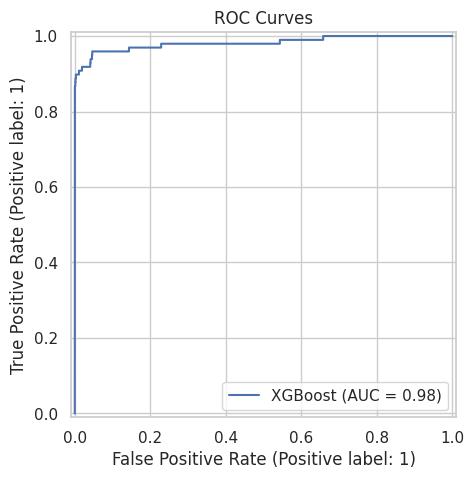

<Figure size 800x500 with 0 Axes>

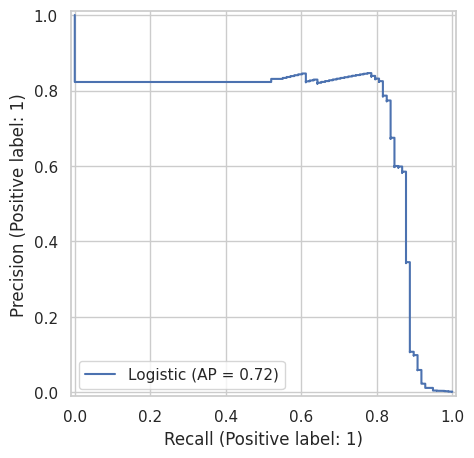

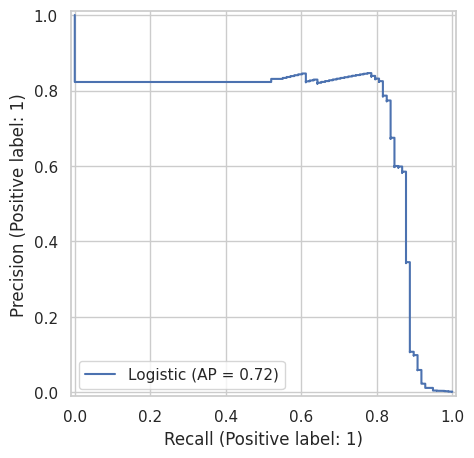

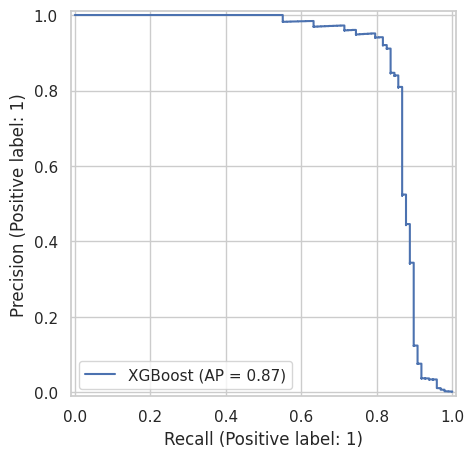

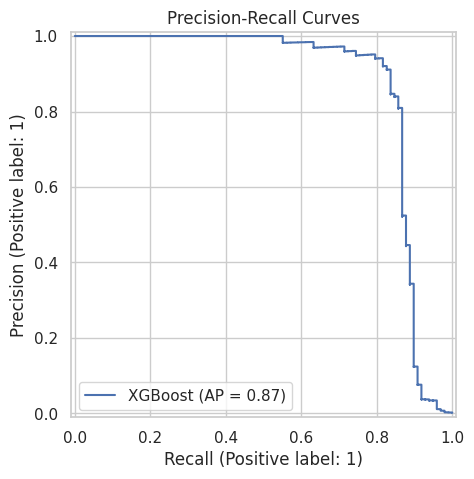

In [22]:
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="Logistic").plot()
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name="XGBoost").plot()
plt.title("ROC Curves")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr, name="Logistic").plot()
PrecisionRecallDisplay.from_predictions(y_test, y_proba_xgb, name="XGBoost").plot()
plt.title("Precision-Recall Curves")
plt.show()


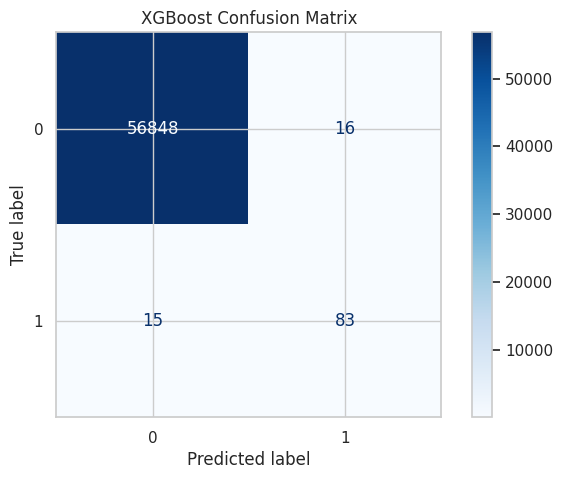

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("XGBoost Confusion Matrix")
plt.show()


In [24]:
stream_df = X_test.copy()
stream_df['true_class'] = y_test.values
stream_df['pred_proba'] = xgb_clf.predict_proba(X_test)[:,1]
stream_df['pred_label'] = (stream_df['pred_proba'] >= 0.5).astype(int)

N = 200
stream_subset = stream_df.iloc[:N].copy()
alerts = stream_subset[stream_subset['pred_label']==1]

print(f"Simulated streaming of first {N} transactions. Alerts flagged: {len(alerts)}")
print(alerts[['pred_proba','true_class']].head())


Simulated streaming of first 200 transactions. Alerts flagged: 0
Empty DataFrame
Columns: [pred_proba, true_class]
Index: []


In [25]:
joblib.dump(xgb_clf, "xgb_fraud_detector.joblib")
joblib.dump(scaler, "amount_scaler.joblib")
print("Saved model and scaler to disk.")


Saved model and scaler to disk.


In [26]:
import joblib

# Load model and scaler
xgb_clf = joblib.load("xgb_fraud_detector.joblib")
scaler = joblib.load("amount_scaler.joblib")

print("Loaded model and scaler from disk.")


Loaded model and scaler from disk.


In [28]:
import pandas as pd

# Create new transaction data as a DataFrame
new_data = pd.DataFrame({
    'Time': [10000],
    'V1': [0.1],
    'V2': [-1.2],
    'V3': [0.5],
    # ... include all features V4 to V28
    'V28': [0.02],
    'Amount': [250.0]
})

new_data.head()


,Time,V1,V2,V3,V28,Amount
0,10000,0.1,-1.2,0.5,0.02,250.0


In [30]:
new_data['Amount_scaled'] = scaler.transform(new_data[['Amount']])


In [31]:
import numpy as np

new_data['Hour'] = new_data['Time'] // 3600 % 24
new_data['Hour_sin'] = np.sin(2 * np.pi * new_data['Hour']/24)
new_data['Hour_cos'] = np.cos(2 * np.pi * new_data['Hour']/24)


In [33]:
import pandas as pd
import numpy as np

# Create a single new transaction with all required features
new_data = pd.DataFrame({
    'Time': [10000],
    'V1': [0.1], 'V2': [-1.2], 'V3': [0.5], 'V4': [0.0], 'V5': [0.2],
    'V6': [0.1], 'V7': [0.0], 'V8': [-0.1], 'V9': [0.3], 'V10': [0.0],
    'V11': [-0.2], 'V12': [0.1], 'V13': [0.0], 'V14': [0.2], 'V15': [-0.1],
    'V16': [0.0], 'V17': [0.1], 'V18': [0.0], 'V19': [0.0], 'V20': [0.1],
    'V21': [0.0], 'V22': [-0.1], 'V23': [0.0], 'V24': [0.0], 'V25': [0.0],
    'V26': [0.0], 'V27': [0.0], 'V28': [0.02],
    'Amount': [250.0]
})

# Feature engineering (Amount_scaled, Hour_sin, Hour_cos)
new_data['Amount_scaled'] = scaler.transform(new_data[['Amount']])
new_data['Hour'] = new_data['Time'] // 3600 % 24
new_data['Hour_sin'] = np.sin(2 * np.pi * new_data['Hour'] / 24)
new_data['Hour_cos'] = np.cos(2 * np.pi * new_data['Hour'] / 24)

# Select features in the same order as training
feature_cols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
                'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
                'V21','V22','V23','V24','V25','V26','V27','V28',
                'Amount_scaled','Hour_sin','Hour_cos']

new_data_prepared = new_data[feature_cols]

# Make predictions
predictions = xgb_clf.predict(new_data_prepared)
pred_prob = xgb_clf.predict_proba(new_data_prepared)[:,1]

new_data['Predicted_Class'] = predictions
new_data['Fraud_Probability'] = pred_prob

print(new_data)


    Time   V1   V2   V3   V4   V5   V6   V7   V8   V9  ...  V26  V27   V28  \
0  10000  0.1 -1.2  0.5  0.0  0.2  0.1  0.0 -0.1  0.3  ...  0.0  0.0  0.02   

   Amount  Amount_scaled  Hour  Hour_sin  Hour_cos  Predicted_Class  \
0   250.0       0.646292     2       0.5  0.866025                0   

   Fraud_Probability  
0           0.000226  

[1 rows x 36 columns]


In [34]:
new_data_prepared = X_test.iloc[[0]]  # pick first row
predictions = xgb_clf.predict(new_data_prepared)
pred_prob = xgb_clf.predict_proba(new_data_prepared)[:,1]

print("Prediction:", predictions[0])
print("Fraud Probability:", pred_prob[0])


Prediction: 0
Fraud Probability: 1.2031108e-05
